# Object detection on MRI brain images

* Downloading dataset of brain images with bounding boxes
* Plot distribution of image label classes

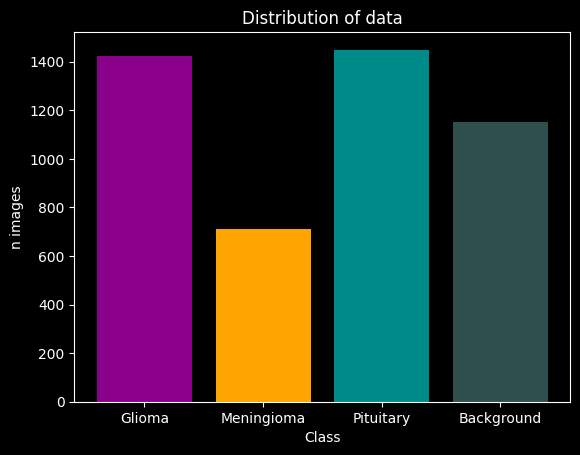

In [1]:
import kagglehub, os
import matplotlib.pyplot as plt

data_set_path = kagglehub.dataset_download("ahmedsorour1/mri-for-brain-tumor-with-bounding-boxes")

# According to mri-for-brain-tumor-with-bounding-boxes dataset labels
class_labels = { 
    0: 'Glioma',
    1: 'Meningioma',
    3: 'Pituitary', 
    2: 'Background', # Reorder to have background last, but keep mapping
}

class_colors = {
    0: 'darkmagenta',
    1: 'orange',
    3: 'darkcyan',
    2: 'darkslategray',
}

def count_files_per_subdir(directory):
    n_files_per_subdir = {}
    for root in os.listdir(directory):
        n_files_per_subdir[root] = len([image for image in os.listdir(os.path.join(directory, root, 'images'))])
    return n_files_per_subdir

n_images_per_category = count_files_per_subdir(f'{data_set_path}/Train/')

plt.style.use('dark_background')
plt.bar(class_labels.values(), n_images_per_category.values(), color=list(class_colors.values()))

plt.xlabel("Class")
plt.ylabel("n images")
title = plt.title("Distribution of data")

* Copying all `Train` images and labels into folder `datasets`
* Split `Train` set into `train` and `validation` set
* TODO: Use `datasets/Validation` as `test` set

In [2]:
import numpy as np

root='datasets'
!rm -rf {root}
!mkdir -p {root}/train/images
!mkdir -p {root}/train/labels
!mkdir -p {root}/validation/images
!mkdir -p {root}/validation/labels
!cp -n {data_set_path}/Train/**/images/* {root}/train/images
!cp -n {data_set_path}/Train/**/labels/* {root}/train/labels

traning_validation_split = .75
data_size = int(len(os.listdir(f'{root}/train/images')))
training_data_size = int(data_size * traning_validation_split)
validation_data_size = data_size - training_data_size

print(f'Training data size: {training_data_size}')
print(f'Validation data size: {validation_data_size}')

seed=0
np.random.seed(seed)
def move_data(source_dir, target_dir, n_files):
  all_images = os.listdir(f'{root}/train/images')
  np.random.shuffle(all_images)
  images_to_move = all_images[:validation_data_size]

  for image_name in images_to_move:
      label_name = image_name.replace('.jpg', '.txt')
      label_path = f'{source_dir}/labels/{label_name}'
      
      if os.path.exists(label_path):
          os.rename(f'{source_dir}/images/{image_name}', f'{target_dir}/images/{image_name}')
          os.rename(label_path, f'{target_dir}/labels/{label_name}')
      else:
          print(image_name + ' is missing label ' + label_path + ', ignoring.')

move_data(f'{root}/train', f'{root}/validation', validation_data_size)

Training data size: 3552
Validation data size: 1185


Define dataset class to init and load data

In [3]:
!pip install pyyaml > /dev/null

import os
import yaml
import torch
from torch.utils.data import Dataset
import torchvision.transforms.functional as F
from torchvision.transforms import ColorJitter
from PIL import Image
from pathlib import Path

class BrainTumorDataset(Dataset):
    def __init__(self, images_dir, labels_dir, transform=None, data_augmentations=None):
        self.transform = transform
        self.data_augmentations = data_augmentations

        image_paths = []
        label_paths = []

        self.populate(image_paths, images_dir)
        self.populate(label_paths, labels_dir)

        def basename(path):
            return os.path.splitext(os.path.basename(path))[0]

        image_basenames = {basename(path) for path in image_paths}
        label_basenames = {basename(path) for path in label_paths}
        matching_basenames = image_basenames & label_basenames

        self.image_paths = [path for path in image_paths if basename(path) in matching_basenames]
        self.label_paths = [path for path in label_paths if basename(path) in matching_basenames]
        self.background_class_index = 2

    def populate(self, file_paths, dir):
      for dir_path, dir_names, file_names in os.walk(dir):
          for file_name in file_names:
              file_path = os.path.join(dir_path, file_name)
              file_paths.append(file_path)
      file_paths.sort()

    def __len__(self):
        return len(self.image_paths)

    def extract_label(self, label_path, image_width, image_height):
        boxes = []
        labels = []
        with open(label_path, 'r') as file:
            for line in file.readlines():
                def scale(center, size, factor):
                    scaled_center = center * factor
                    scaled_size = size * factor
                    half_size = scaled_size / 2
                    return scaled_center - half_size, scaled_center + half_size

                columns = line.strip().split()
                class_id, x_center, y_center, width, height = map(float, columns[:5])
                class_id = int(class_id)
                
                x_min, x_max = scale(x_center, width, image_width)
                y_min, y_max = scale(y_center, height, image_height)

                boxes.append([x_min, y_min, x_max, y_max])
                labels.append(class_id)

        boxes = torch.tensor(boxes, dtype=torch.float32)
        labels = torch.tensor(labels, dtype=torch.int64)

        return boxes, labels

    def augment_data(self, image, boxes):
        probability = .5
        image_width, image_height = image.size
        if self.data_augmentations.random_color_jitter and np.random.random() > probability:
            brightness, contrast, saturation, hue = 0.3, 0.2, 0.2, 0.1
            color_jitter = ColorJitter(brightness, contrast, saturation, hue=hue)
            image = color_jitter(image)
        if self.data_augmentations.random_horizontal_flip and np.random.random() > probability:
            image = F.hflip(image)
            boxes[:, [0, 2]] = image_width - boxes[:, [2, 0]]
        if self.data_augmentations.random_vertical_flip and np.random.random() > probability:
            image = F.vflip(image)
            boxes[:, [1, 3]] = image_height - boxes[:, [3, 1]]
            
        return image, boxes
        
    def __getitem__(self, index):
        image = Image.open(self.image_paths[index]).convert("RGB")
        image_width, image_height = image.size

        label_path = self.label_paths[index]
        boxes, labels = self.extract_label(label_path, image_width, image_height)

        if self.data_augmentations is not None:
           image, boxes = self.augment_data(image, boxes)
       
        if self.transform:
           image = self.transform(image)
           resize_scale = torch.tensor([image.shape[2] / image_height,
                                        image.shape[1] / image_width] * 2)
           boxes = boxes * resize_scale

        return {'image': image, 'boxes': boxes, 'labels': labels}

def collate_fn(batch):
    images = [item['image'] for item in batch]
    boxes = [item['boxes'] for item in batch]
    labels = [item['labels'] for item in batch]

    return {
        'images': torch.stack(images, dim=0),
        'boxes': boxes,
        'labels': labels
    }

Instantiate batch data loaders

In [4]:
from torch.utils.data import DataLoader, Subset
from torchvision import transforms
from dataclasses import dataclass

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
if torch.cuda.is_available():
    torch.cuda.set_device(0)
    torch.cuda.manual_seed_all(seed)
else:
    torch.manual_seed(seed)
print('Using device:', device)

@dataclass
class DataAugmentations:
    random_color_jitter: bool
    random_horizontal_flip: bool
    random_vertical_flip: bool

data_augmentations = DataAugmentations(random_color_jitter = True,
                                       random_horizontal_flip=True,
                                       random_vertical_flip=False, # Upside down images not represented in data
                                       )
target_image_size = 256
transform = transforms.Compose([
    transforms.Resize((target_image_size, target_image_size)),
    transforms.ToTensor()
])

train_dataset = BrainTumorDataset(images_dir=root+'/train/images',
                                  labels_dir=root+'/train/labels',
                                  transform=transform,
                                  data_augmentations=data_augmentations)

validation_dataset = BrainTumorDataset(images_dir=root+'/validation/images',
                                       labels_dir=root+'/validation/labels',
                                       transform=transform)
# Shuffle validation set once to get variation when plotting, as opposed to consequative scan images
shuffled_indices = torch.randperm(len(validation_dataset)).tolist()
validation_dataset = Subset(validation_dataset, shuffled_indices) 
    
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)
validation_loader = DataLoader(validation_dataset, batch_size=16, shuffle=False, collate_fn=collate_fn)

Using device: cuda


Visualize sample data from training and validation set

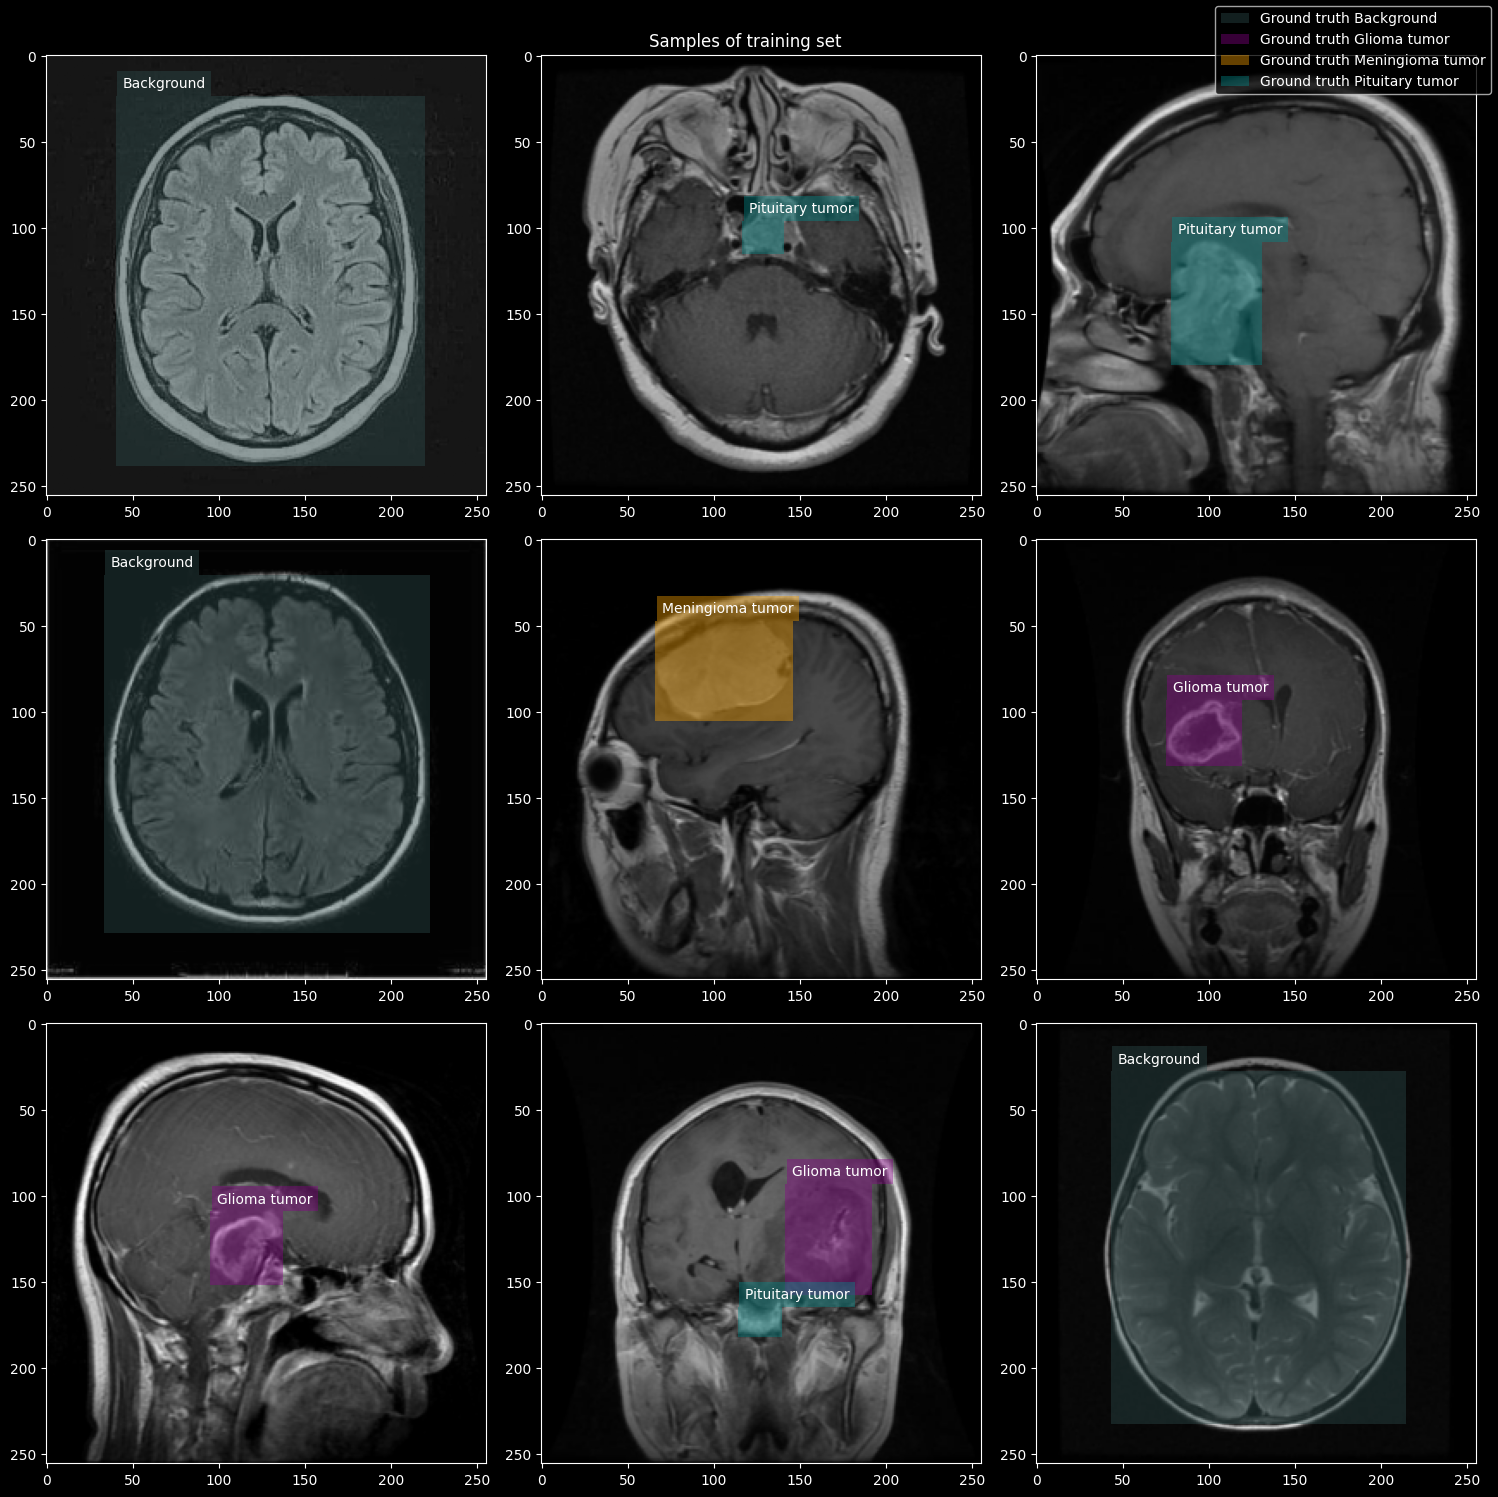

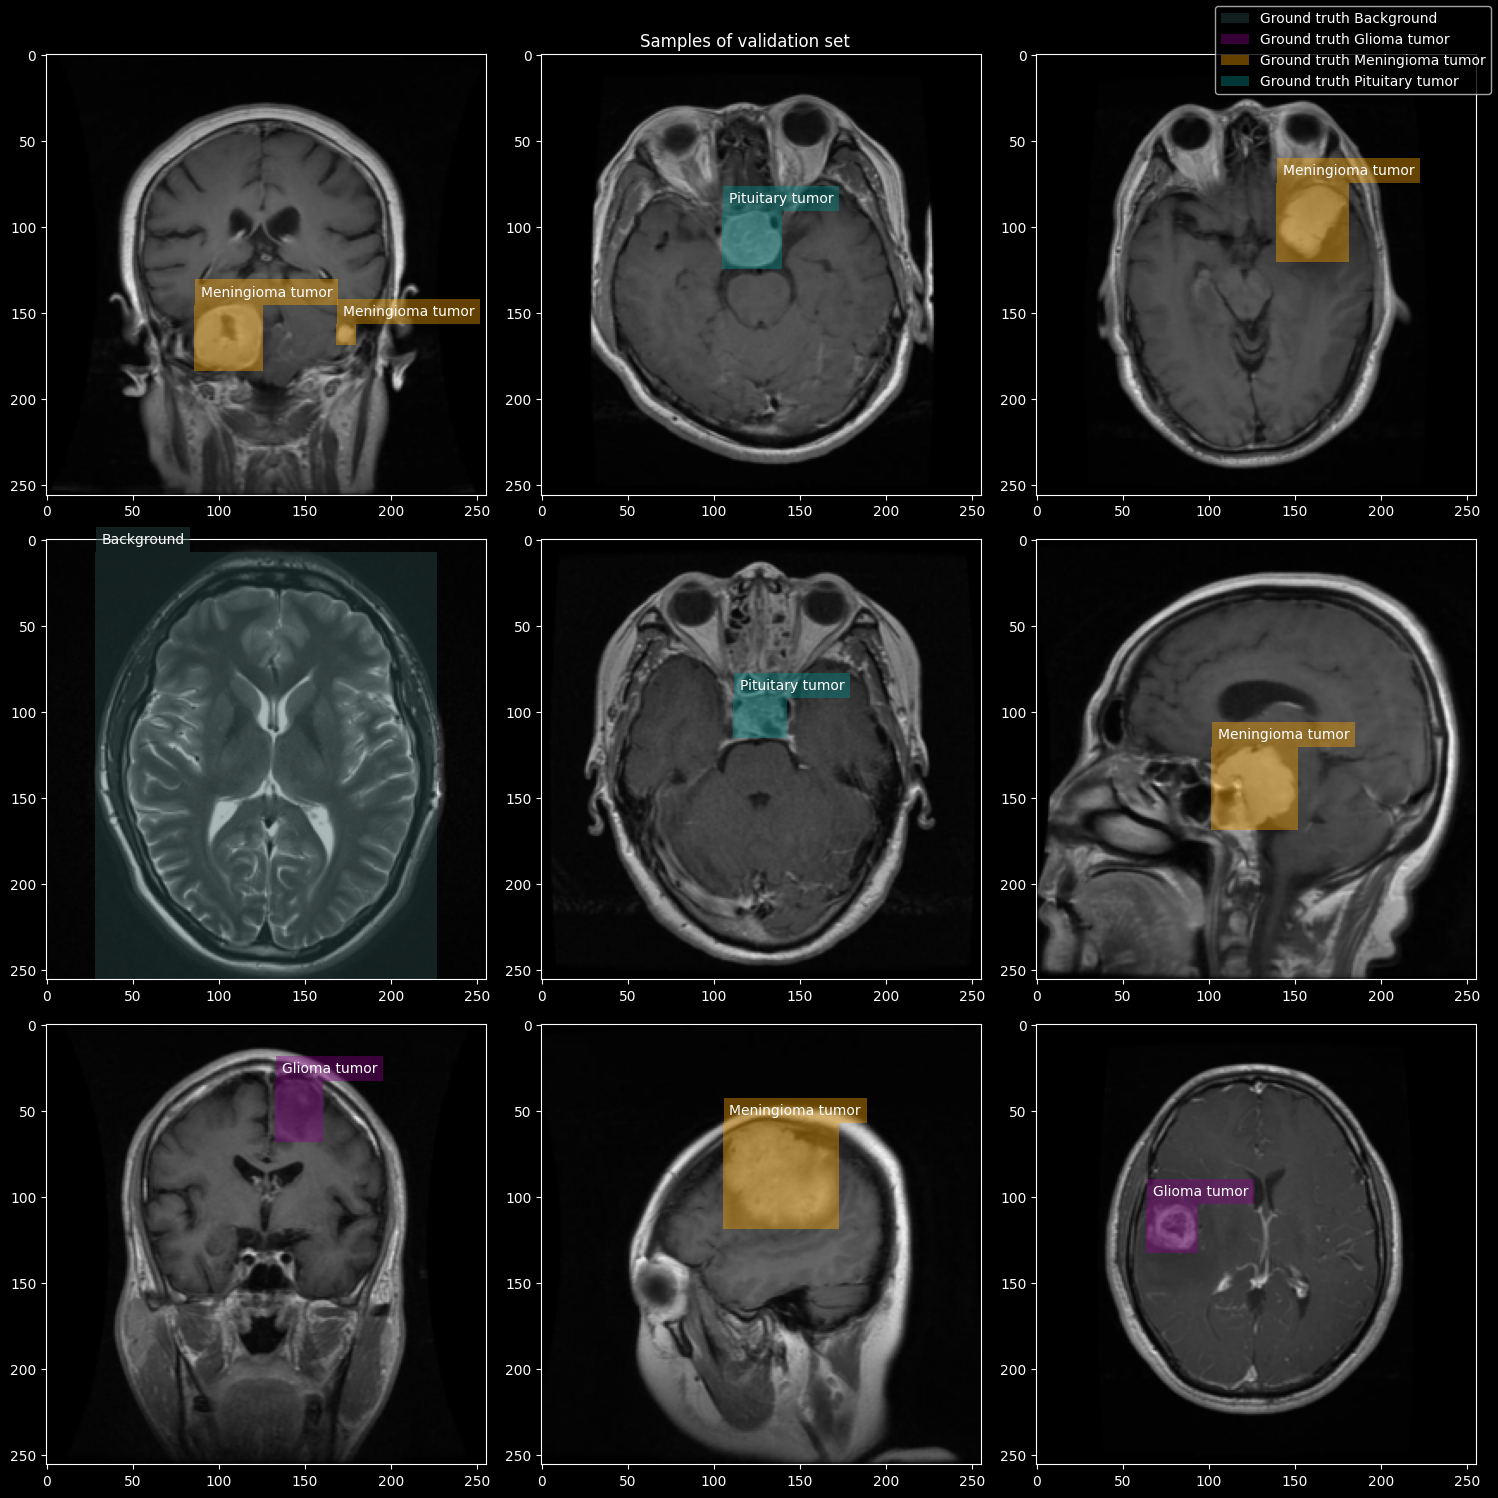

In [5]:
from matplotlib.colors import to_rgba
from collections import OrderedDict

confidence_threshold = .5

def plot_boxes(ax, image, boxes, labels, prediction_confidences=None):
    ax.imshow(image)
    for i, label in enumerate(labels):
        x_min, y_min, x_max, y_max = boxes[i]
        width, height = x_max - x_min,  y_max - y_min
        
        class_label = class_labels[label.item()]
        class_label += ' tumor' if class_label != 'Background' else ''
        class_color = class_colors[label.item()]
        legend = class_label
        transparency=.4
        line_width=3
        bounding_box = plt.Rectangle((x_min, y_min),
                                     width, height,
                                     linewidth=line_width,
                                     label=legend)
        label_text = ax.text(x_min+4, y_min-5, class_label)
        label_text.set_bbox(dict(facecolor=to_rgba(class_color, alpha=transparency)))
        if prediction_confidences is not None:
            class_keys = list(class_labels.keys())
            label_index = class_keys.index(int(label.item()))
            label_text.set_position((label_text.get_position()[0]+width,
                                     label_text.get_position()[1]+height+(label_index-1)*15))
            confidence_label = f' confidence: {prediction_confidences[i]:.2f}'
            bounding_box.set_edgecolor(class_color)
            bounding_box.set_facecolor('none')
            bounding_box.set_label('Predicted ' + legend)
            label_text.set_text(class_label + confidence_label)
            label_box = label_text.get_bbox_patch()
            label_box.set_edgecolor(class_color)
            label_box.set_facecolor('none')
            label_box.set_linewidth(line_width)  
        else:
            bounding_box.set_label('Ground truth ' + legend)
            bounding_box.set_edgecolor('none')
            bounding_box.set_facecolor(to_rgba(class_color, alpha=transparency))
            label_box = label_text.get_bbox_patch()
            label_box.set_edgecolor('none')
        ax.add_patch(bounding_box)

def add_legends(fig):
    box_legends = [ax.get_legend_handles_labels() for ax in fig.axes]
    box_legends, labels = [sum(lol, []) for lol in zip(*box_legends)]
    box_legends = sorted(zip(labels, box_legends), key=lambda x: x[0])  # Sort by label
    labels, box_legends = zip(*box_legends)
    box_labeled_legends = OrderedDict(zip(labels, box_legends))
    fig.legend(box_labeled_legends.values(), box_labeled_legends.keys())


def visualize_data_samples(title, batch, predictions=None):
      rows = 3
      cols = 3
      fig, axes = plt.subplots(rows, cols, figsize=(5*cols, 5*rows))
      axes = axes.flatten()
      plt.suptitle(title)
      for i in range(rows * cols):
          image = batch['images'][i].permute(1, 2, 0).cpu().numpy()
          boxes = batch['boxes'][i]
          labels = batch['labels'][i]
          plot_boxes(axes[i], image, boxes, labels)
          plt.tight_layout()
      if predictions is not None:
          for i, prediction in enumerate(predictions):
              if i > rows * cols - 1:
                  break
              image = batch['images'][i].permute(1, 2, 0).cpu().numpy()
              boxes = prediction.boxes.xyxy
              confidences = prediction.boxes.conf
              classes = prediction.boxes.cls
                  
              confident_prediction_indices = confidences > confidence_threshold
              boxes = boxes[confident_prediction_indices].cpu()
              confidences = confidences[confident_prediction_indices].cpu()
              classes = classes[confident_prediction_indices].cpu()
              plot_boxes(axes[i], image, boxes, classes, confidences)
      add_legends(fig)
      plt.show()

training_batch = next(iter(train_loader))
visualize_data_samples('Samples of training set', training_batch)
validation_batch = next(iter(validation_loader))
visualize_data_samples('Samples of validation set', validation_batch)

Download pretrained model

In [6]:
# Using Ultralytics pretrained model
# Jocher, G., Qiu, J., & Chaurasia, A. (2023). Ultralytics YOLO (Version 8.0.0) [Computer software]. https://github.com/ultralytics/ultralytics

!pip install ultralytics > /dev/null
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu117 > /dev/null
from ultralytics import YOLO

!rm runs -rf
model = YOLO('yolo11n.pt')

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


100%|██████████| 5.35M/5.35M [00:00<00:00, 71.5MB/s]


Configure data paths and train model on MRI data

In [7]:
import yaml
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

num_classes = len(class_labels)

data = {
    'path': './',
    'train': 'train',
    'val': 'validation',
    'nc': num_classes,
    'names': list(class_labels.values())
}

with open(f'{root}/data.yaml', 'w') as f:
    yaml.dump(data, f)

!pip install -U ipywidgets
model.train(data=root+'/data.yaml', 
            epochs=100, 
            imgsz=target_image_size, 
            batch=32,
            device=device, 
            patience=5,
            dropout=1e-2,
            optimizer='SGD',
            lr0=5e-2,
            verbose=False,
           )

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.8/139.8 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 214.4/214.4 kB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 47.0 MB/s eta 0:00:00
  Attempting uninstall: widgetsnbextension
    Found existing installation: widgetsnbextension 3.6.9
    Uninstalling widgetsnbextension-3.6.9:
      Successfully uninstalled widgetsnbextension-3.6.9
  Attempting uninstall: jupyterlab-widgets
    Found existing installation: jupyterlab_widgets 3.0.11
    Uninstalling jupyterlab_widgets-3.0.11:
      Successfully uninstalled jupyterlab_widgets-3.0.11
  Attempting uninstall: ipywidgets
    Found existing installation: ipywidgets 7.7.1
    Uninstalling ipywidgets-7.7.1:
      Successfully uninstalled ipywidgets-7.7.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 0.22.0

100%|██████████| 755k/755k [00:00<00:00, 16.4MB/s]
2025-01-02 19:22:55,760	INFO util.py:124 -- Outdated packages:
  ipywidgets==7.7.1 found, needs ipywidgets>=8
Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
2025-01-02 19:22:57,636	INFO util.py:124 -- Outdated packages:
  ipywidgets==7.7.1 found, needs ipywidgets>=8
Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


Overriding model.yaml nc=80 with nc=4

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      6640  ultralytics.nn.modules.block.C3k2            [32, 64, 1, False, 0.25]      
  3                  -1  1     36992  ultralytics.nn.modules.conv.Conv             [64, 64, 3, 2]                
  4                  -1  1     26080  ultralytics.nn.modules.block.C3k2            [64, 128, 1, False, 0.25]     
  5                  -1  1    147712  ultralytics.nn.modules.conv.Conv             [128, 128, 3, 2]              
  6                  -1  1     87040  ultralytics.nn.modules.block.C3k2            [128, 128, 1, True]           
  7                  -1  1    295424  ultralytics

train: Scanning /kaggle/working/datasets/train/labels... 3552 images, 0 backgrounds, 0 corrupt: 100%|██████████| 3552/3552 [00:03<00:00, 1085.46it/s]


train: New cache created: /kaggle/working/datasets/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/opt/conda/lib/python3.10/site-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.24 (you have 1.4.17). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
val: Scanning /kaggle/working/datasets/validation/labels... 1185 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1185/1185 [00:01<00:00, 1039.20it/s]

val: New cache created: /kaggle/working/datasets/validation/labels.cache


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: SGD(lr=0.05, momentum=0.937) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 256 train, 256 val
Using 2 dataloader workers
Logging results to runs/detect/train
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100     0.889G      1.266      2.298      1.149         64        256: 100%|██████████| 111/111 [00:26<00:00,  4.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:08<00:00,  2.34it/s]


                   all       1185       1337      0.353      0.428      0.391      0.216

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      0.82G      1.482      1.608      1.228         80        256: 100%|██████████| 111/111 [00:24<00:00,  4.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:06<00:00,  2.95it/s]

                   all       1185       1337      0.446      0.608      0.545      0.297



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100     0.818G      1.526      1.552      1.254         53        256: 100%|██████████| 111/111 [00:22<00:00,  4.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:06<00:00,  2.93it/s]

                   all       1185       1337      0.561      0.227     0.0687     0.0282



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100     0.826G      1.488      1.529      1.232         62        256: 100%|██████████| 111/111 [00:22<00:00,  4.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:06<00:00,  2.88it/s]

                   all       1185       1337      0.755        0.3      0.451      0.256



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100     0.826G       1.39      1.269      1.184         53        256: 100%|██████████| 111/111 [00:22<00:00,  4.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:06<00:00,  2.88it/s]

                   all       1185       1337      0.515      0.594      0.587      0.357



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100     0.822G       1.33      1.116      1.166         49        256: 100%|██████████| 111/111 [00:22<00:00,  4.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:06<00:00,  2.86it/s]

                   all       1185       1337      0.722      0.678      0.721      0.451



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100     0.824G      1.272      1.054      1.142         49        256: 100%|██████████| 111/111 [00:22<00:00,  4.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:06<00:00,  2.94it/s]

                   all       1185       1337      0.737      0.706      0.799      0.522



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100     0.818G      1.221     0.9846      1.124         68        256: 100%|██████████| 111/111 [00:22<00:00,  5.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:06<00:00,  2.98it/s]

                   all       1185       1337      0.674       0.57      0.641      0.414



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100     0.824G      1.195     0.9433      1.103         59        256: 100%|██████████| 111/111 [00:22<00:00,  4.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:06<00:00,  2.96it/s]

                   all       1185       1337      0.778      0.721       0.79      0.521



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100     0.818G      1.191     0.9178       1.11         64        256: 100%|██████████| 111/111 [00:22<00:00,  4.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:06<00:00,  3.01it/s]

                   all       1185       1337      0.764      0.702      0.776      0.514



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100     0.822G      1.173     0.9067      1.102         53        256: 100%|██████████| 111/111 [00:22<00:00,  4.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:06<00:00,  2.99it/s]


                   all       1185       1337      0.829       0.76      0.831      0.575

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100     0.818G      1.145     0.8897      1.089         48        256: 100%|██████████| 111/111 [00:22<00:00,  4.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:06<00:00,  2.97it/s]

                   all       1185       1337      0.853      0.801      0.867      0.601



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100     0.822G      1.129     0.8728      1.088         68        256: 100%|██████████| 111/111 [00:22<00:00,  4.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:06<00:00,  2.97it/s]

                   all       1185       1337      0.824      0.791      0.847      0.591



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100     0.818G      1.117     0.8467       1.08         52        256: 100%|██████████| 111/111 [00:22<00:00,  4.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:06<00:00,  3.01it/s]

                   all       1185       1337      0.838      0.771      0.841      0.579



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100     0.822G      1.108     0.8319       1.08         62        256: 100%|██████████| 111/111 [00:22<00:00,  4.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:06<00:00,  3.02it/s]


                   all       1185       1337      0.841      0.787      0.864       0.59

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100     0.818G      1.093     0.8096      1.077         77        256: 100%|██████████| 111/111 [00:22<00:00,  4.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:06<00:00,  3.04it/s]

                   all       1185       1337      0.865      0.824      0.889      0.626



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100     0.822G      1.084     0.8121      1.077         64        256: 100%|██████████| 111/111 [00:22<00:00,  4.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:06<00:00,  3.02it/s]

                   all       1185       1337      0.875      0.826      0.888      0.629



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100     0.818G      1.073     0.7867       1.06         59        256: 100%|██████████| 111/111 [00:22<00:00,  5.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:06<00:00,  2.94it/s]


                   all       1185       1337      0.877      0.828      0.901      0.641

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100     0.822G      1.062      0.793      1.066         61        256: 100%|██████████| 111/111 [00:22<00:00,  5.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:06<00:00,  2.92it/s]

                   all       1185       1337      0.779      0.789      0.857      0.604



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100     0.818G       1.08     0.7725      1.063         58        256: 100%|██████████| 111/111 [00:21<00:00,  5.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:06<00:00,  2.93it/s]

                   all       1185       1337      0.862      0.799      0.883      0.624



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100     0.822G      1.056     0.7615      1.059         57        256: 100%|██████████| 111/111 [00:22<00:00,  4.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:06<00:00,  3.00it/s]

                   all       1185       1337      0.824       0.83      0.882      0.628



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100     0.818G      1.031     0.7426       1.05         50        256: 100%|██████████| 111/111 [00:22<00:00,  4.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:06<00:00,  3.02it/s]

                   all       1185       1337      0.863      0.797      0.867      0.629



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100     0.822G      1.041     0.7494      1.059         53        256: 100%|██████████| 111/111 [00:22<00:00,  4.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:06<00:00,  2.97it/s]

                   all       1185       1337       0.88      0.827      0.894      0.642
EarlyStopping: Training stopped early as no improvement observed in last 5 epochs. Best results observed at epoch 18, best model saved as best.pt.
To update EarlyStopping(patience=5) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.



23 epochs completed in 0.192 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 5.4MB
Optimizer stripped from runs/detect/train/weights/best.pt, 5.4MB

Validating runs/detect/train/weights/best.pt...
Ultralytics 8.3.56 🚀 Python-3.10.14 torch-2.4.0 CUDA:0 (Tesla T4, 15095MiB)
YOLO11n summary (fused): 238 layers, 2,582,932 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:07<00:00,  2.58it/s]


                   all       1185       1337      0.878      0.828      0.901      0.641
Speed: 0.1ms preprocess, 0.9ms inference, 0.0ms loss, 1.4ms postprocess per image
Results saved to runs/detect/train


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 3])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x79b018941c60>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0

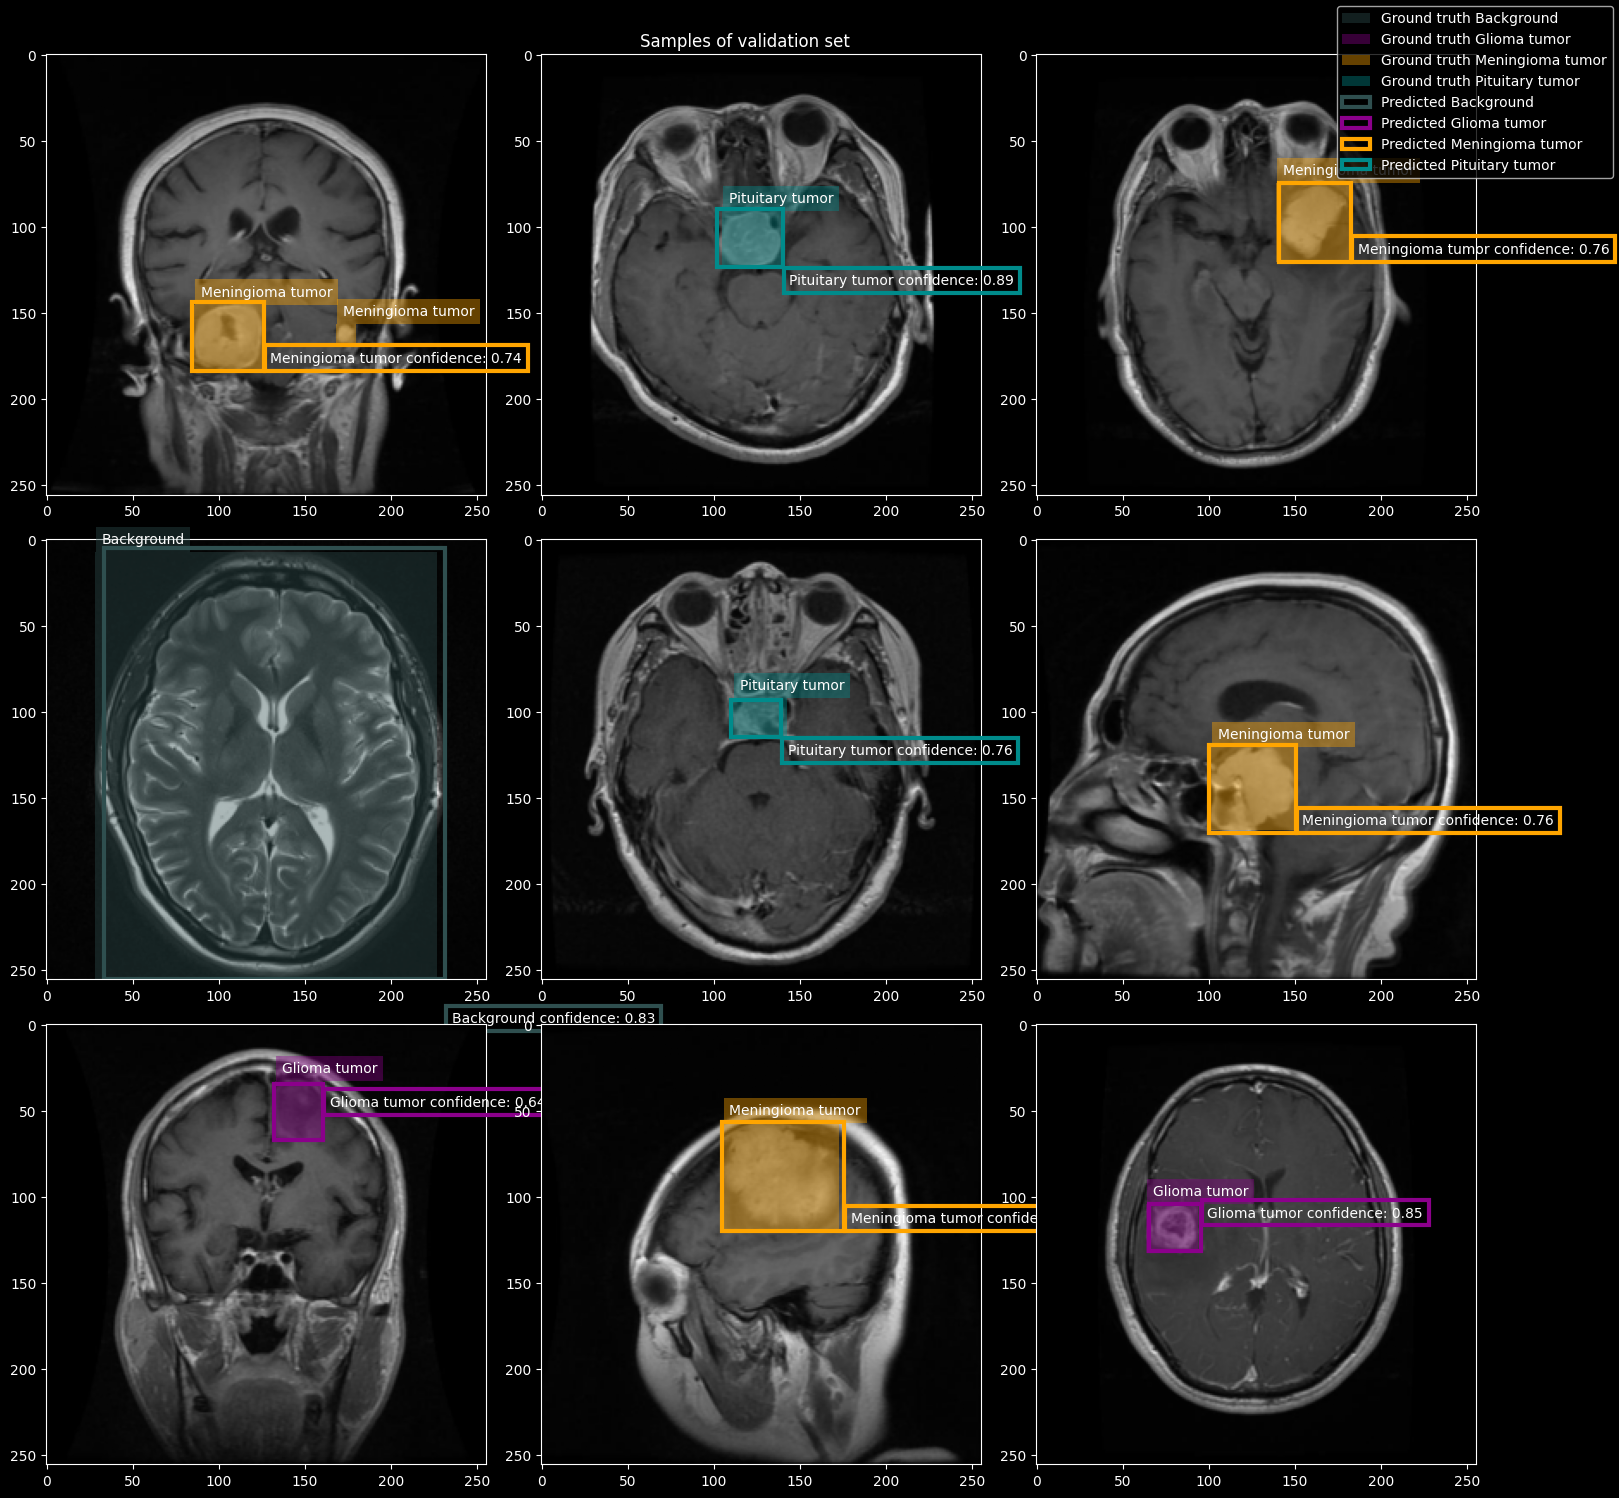

In [8]:
best_models = !find runs -name best.pt | sort
model = YOLO(best_models[-1])
model.eval()
validation_batch = next(iter(validation_loader))
predictions = model.predict(validation_batch['images'].half().to(device), verbose=False)
visualize_data_samples('Samples of validation set', validation_batch, predictions)

Calculate evaluation metrics
* Precision
* Recall
* F1 score
* Confusion matrix

In [9]:
from scipy.optimize import linear_sum_assignment
import numpy as np
from torchvision.ops import box_iou

def calculate_scores(true_positives, false_positives, false_negatives):
    epsilon = 1e-6
    precision = true_positives / (true_positives + false_positives + epsilon)
    recall = true_positives / (true_positives + false_negatives + epsilon)
    f1_score = 2 * precision * recall / (precision + recall + epsilon)
    
    return precision, recall, f1_score

def calculate_metrics(pred_boxes, pred_labels, true_boxes, true_labels, iou_threshold):
    pred_boxes = pred_boxes.clone().detach().to(device)
    pred_labels = pred_labels.clone().detach().to(device)
    true_boxes = true_boxes.clone().detach().to(device)
    true_labels = true_labels.clone().detach().to(device)

    iou_matrix = box_iou(true_boxes, pred_boxes)
    cost_matrix = 1 - iou_matrix.cpu().numpy()
    ground_truth_indices, prediction_indices = linear_sum_assignment(cost_matrix)

    confusion_matrix = np.zeros((num_classes, num_classes), dtype=int)
    class_keys = list(class_labels.keys())
    class_values = list(class_labels.values())
    background_index = class_values.index('Background')
    matched_true_boxes = set()
    
    for ground_truth_idx, prediction_idx in zip(ground_truth_indices, prediction_indices):
        if iou_matrix[ground_truth_idx, prediction_idx] >= iou_threshold:
            true_label = int(true_labels[ground_truth_idx].item())
            predicted_label = int(pred_labels[prediction_idx].item())
            true_index =  class_keys.index(true_label)
            predicted_index =  class_keys.index(predicted_label)
            confusion_matrix[true_index, predicted_index] += 1
            matched_true_boxes.add(ground_truth_idx)
        else:
            predicted_label = int(pred_labels[prediction_idx].item())
            predicted_index =  class_keys.index(predicted_label)
            confusion_matrix[background_index, predicted_index] += 1

    unmatched_ground_truth_boxes = set(range(len(true_boxes))) - matched_true_boxes
    for ground_truth_idx in unmatched_ground_truth_boxes:
        true_label = int(true_labels[ground_truth_idx].item())
        true_index =  class_keys.index(true_label)
        confusion_matrix[true_index, background_index] += 1

    true_positives = np.sum(np.diag(confusion_matrix))
    false_positives = np.sum(confusion_matrix[:, :background_index]) \
                    - np.sum(np.diag(confusion_matrix[:background_index, :background_index]))
    false_negatives = np.sum(confusion_matrix[:background_index, background_index])
    
    precision, recall, f1_score = calculate_scores(true_positives, false_positives, false_negatives)

    return precision, recall, f1_score, confusion_matrix

def evaluate(iou_threshold):
    with torch.no_grad():
        total_precision = 0.
        total_recall = 0.
        total_f1_score = 0.
        num_samples = 0
        confusion_matrix = np.zeros((num_classes, num_classes), dtype=int)
        for batch in validation_loader:
            predictions = model.predict(batch['images'].half().to(device), verbose=False);
            for i, prediction in enumerate(predictions):
                predicted_boxes = prediction.boxes.xyxy
                predicted_confidences = prediction.boxes.conf
                predicted_classes = prediction.boxes.cls
                confident_prediction_indices = predicted_confidences > confidence_threshold
                predicted_boxes = predicted_boxes[confident_prediction_indices]
                predicted_confidences = predicted_confidences[confident_prediction_indices]
                predicted_classes = predicted_classes[confident_prediction_indices]
                ground_truth_boxes = batch['boxes'][i]
                ground_truth_labeles = batch['labels'][i]
                
                precision, recall, f1_score, batch_confusion_matrix = calculate_metrics(predicted_boxes,
                                                                                        predicted_classes,
                                                                                        ground_truth_boxes,
                                                                                        ground_truth_labeles,
                                                                                        iou_threshold)
                confusion_matrix += batch_confusion_matrix
                total_precision += precision
                total_recall += recall
                total_f1_score += f1_score
                num_samples += 1
        if num_samples == 0:
            mean_precision, mean_recall, mean_f1_score = 0., 0., 0.
        else:
            mean_precision = total_precision / num_samples
            mean_recall = total_recall / num_samples
            mean_f1_score = total_f1_score / num_samples
            
        return mean_precision, mean_recall, mean_f1_score, confusion_matrix

mean_precision, mean_recall, mean_f1_score, confusion_matrix = evaluate(iou_threshold=.5);

Mean Precision: 0.8689, 
Mean Recall: 0.8394,  
Mean F1 score: 0.8482


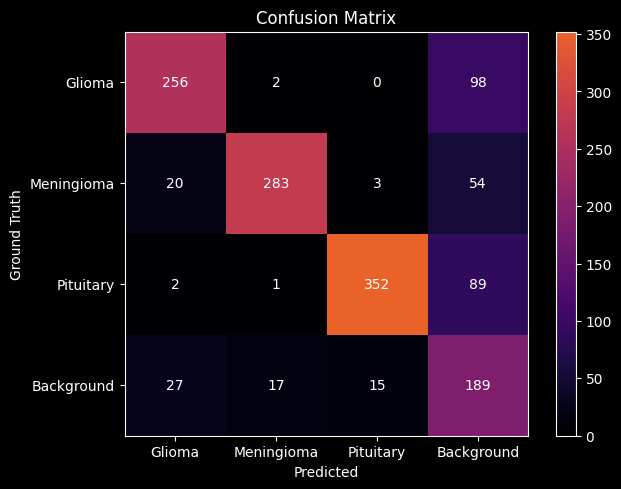

In [10]:
from matplotlib.colors import LinearSegmentedColormap

def plot_confusion_matrix(confusion_matrix):
    cmap = plt.get_cmap('inferno')
    colors = cmap(np.linspace(0., .65, cmap.N // 2))
    heatmap = LinearSegmentedColormap.from_list('Upper Half', colors)
    plt.imshow(confusion_matrix, interpolation='nearest', cmap=heatmap)
    plt.title('Confusion Matrix')
    plt.colorbar()

    tick_marks = np.arange(len(class_labels))
    plt.xticks(tick_marks, list(class_labels.values()))
    plt.yticks(tick_marks, list(class_labels.values()))
    for i in range(num_classes):
        for j in range(num_classes):
            plt.text(j, i, confusion_matrix[i, j], color='white',
                     ha='center', va='center')

    plt.tight_layout()
    plt.ylabel('Ground Truth')
    plt.xlabel('Predicted')
    plt.show()

print(f"Mean Precision: {mean_precision:.4f}, \nMean Recall: {mean_recall:.4f},  \nMean F1 score: {mean_f1_score:.4f}")
plot_confusion_matrix(confusion_matrix)